In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys


import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

In [4]:
BASE_DIR = "../../../data/cassava-leaf-disease-classification"
train_dir = os.path.join(BASE_DIR, 'train_images/')
test_dir = os.path.join(BASE_DIR, "test_images/")
print(train_dir)

../../../data/cassava-leaf-disease-classification\train_images/


In [5]:
#日付を取得
import datetime as dt

dt_now = dt.datetime.now()
directory_name = dt_now.strftime('%Y%m%d%H')
create_directory = BASE_DIR + '/models/' + directory_name
if(not (os.path.exists(create_directory))):
    os.mkdir(create_directory)

In [6]:
## config
class CFG:
    num_workers=0
    model_name='efficientnet-b3'
    size=300
    batch_size=8
    target_size=5
    target_col='label'
    n_fold=3
    seed = 2021
    learning_rate = 1e-5
    num_epochs = 20
    n_split = 3
    checkpoint_thres_loss = 0.5
    checkpoint_thres_acc = 80
    weights=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]) #see 000_EDA.ipynb
    RandomHorizontalFlip = True,
    CenterCrop = True

In [7]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)

In [8]:
df_train = pd.read_csv(BASE_DIR + "/train.csv")
df_train.head()


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:

model = EfficientNet.from_pretrained(CFG.model_name)
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, CFG.target_size)

Loaded pretrained weights for efficientnet-b3


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [11]:
if CFG.RandomHorizontalFlip:
    if CFG.CenterCrop:
        data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(CFG.size),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
    else:
        data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(CFG.size),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        
else:
    if CFG.CenterCrop:
        data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(CFG.size),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
    else:
        data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(CFG.size),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

In [12]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform, output_label=True):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.output_label = output_label

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.iloc[index,0]
        if self.output_label:
            label = self.df.iloc[index,1]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = plt.imread(img_path)
        image = self.transform(image)

        # do label smoothing
        if self.output_label == True:
            return image, label
        else:
            return image

In [13]:
def Plot_Model_History(loss_tra_li,acc_tra_li,loss_val_li,acc_val_li):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 2, 1)
    plt.plot(loss_tra_li, label="train_loss")
    plt.plot(loss_val_li, label="val_loss")
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(acc_tra_li, label="train_acc")
    plt.plot(acc_val_li, label="val_acc")
    plt.legend()
    plt.show()
    
def Save_histroy(init=False):
    filename = "./log/" + directory_name
    if init:
        with open(filename+'.txt','w') as f:
            f.write("model: {}, lr: {}, weights: {}. batchsize: {}, kfold: {}, epoch: {}, RandomHorizontalFlip:{},CenterCrop: {} \n" .format(CFG.model_name,CFG.learning_rate,CFG.weights, CFG.batch_size,CFG.n_split,CFG.num_epochs,CFG.RandomHorizontalFlip,CFG.CenterCrop))
    else:
        with open(filename+'.txt',mode='a') as f:
            f.write('\nkfold: {}, epoch: {}. train_loss: {}, train_acc: {}. val_loss: {}, val_acc: {}'
                    .format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
            
            
            
def Confusion_Matrix(train_true_li,train_pred_li,val_true_li,val_pred_li):
    plt.figure(figsize=(10,5))
    train_cm = confusion_matrix(train_true_li,train_pred_li)
    val_cm = confusion_matrix(val_true_li,val_pred_li)
    plt.subplot(1,2,1)
    sns.heatmap(train_cm, annot=True, cmap='Blues', cbar=False)
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.title("train")
    
    plt.subplot(1,2,2)
    sns.heatmap(val_cm, annot=True, cmap='Blues', cbar=False)
    plt.title("val")
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.show()

Loaded pretrained weights for efficientnet-b3
Kfold: 1 - Epoch: 1 - Train_Loss: 1.012861 - Train_Acc: 64.2036 - Val_Loss: 0.794615 - Val_Acc: 74.372634
Kfold: 1 - Epoch: 2 - Train_Loss: 0.740480 - Train_Acc: 73.5418 - Val_Loss: 0.632933 - Val_Acc: 78.662554
Kfold: 1 - Epoch: 3 - Train_Loss: 0.626636 - Train_Acc: 77.6010 - Val_Loss: 0.555258 - Val_Acc: 80.555166
Kfold: 1 - Epoch: 4 - Train_Loss: 0.579374 - Train_Acc: 79.3326 - Val_Loss: 0.522390 - Val_Acc: 81.606617
Kfold: 1 - Epoch: 5 - Train_Loss: 0.541628 - Train_Acc: 80.8188 - Val_Loss: 0.503901 - Val_Acc: 82.924436
Kfold: 1 - Epoch: 6 - Train_Loss: 0.506997 - Train_Acc: 82.1509 - Val_Loss: 0.488650 - Val_Acc: 83.288939
Kfold: 1 - Epoch: 7 - Train_Loss: 0.477392 - Train_Acc: 83.4128 - Val_Loss: 0.480737 - Val_Acc: 83.555306
Kfold: 1 - Epoch: 8 - Train_Loss: 0.465027 - Train_Acc: 83.5390 - Val_Loss: 0.471980 - Val_Acc: 84.102061
Kfold: 1 - Epoch: 9 - Train_Loss: 0.445179 - Train_Acc: 84.2120 - Val_Loss: 0.476296 - Val_Acc: 83.933829


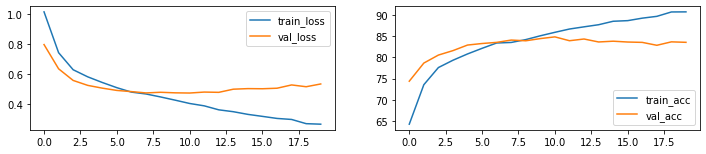

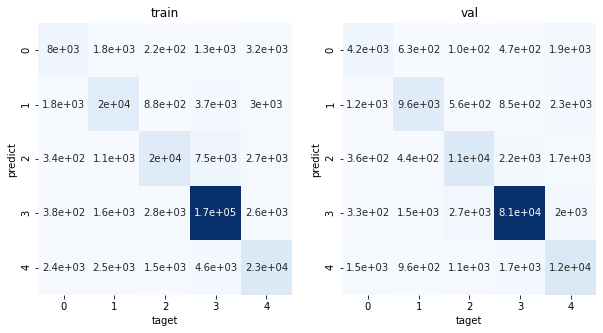

Loaded pretrained weights for efficientnet-b3
Kfold: 2 - Epoch: 1 - Train_Loss: 1.004308 - Train_Acc: 65.6011 - Val_Loss: 0.881697 - Val_Acc: 72.966910
Kfold: 2 - Epoch: 2 - Train_Loss: 0.750362 - Train_Acc: 72.7865 - Val_Loss: 0.662180 - Val_Acc: 78.070667
Kfold: 2 - Epoch: 3 - Train_Loss: 0.649462 - Train_Acc: 76.7473 - Val_Loss: 0.586453 - Val_Acc: 79.753225
Kfold: 2 - Epoch: 4 - Train_Loss: 0.585227 - Train_Acc: 79.1518 - Val_Loss: 0.531160 - Val_Acc: 81.604038
Kfold: 2 - Epoch: 5 - Train_Loss: 0.545047 - Train_Acc: 80.5328 - Val_Loss: 0.515329 - Val_Acc: 81.618059
Kfold: 2 - Epoch: 6 - Train_Loss: 0.523087 - Train_Acc: 81.3670 - Val_Loss: 0.496723 - Val_Acc: 82.431296
Kfold: 2 - Epoch: 7 - Train_Loss: 0.506284 - Train_Acc: 82.2713 - Val_Loss: 0.489219 - Val_Acc: 82.908020
Kfold: 2 - Epoch: 8 - Train_Loss: 0.472317 - Train_Acc: 83.2878 - Val_Loss: 0.478060 - Val_Acc: 83.258553
Kfold: 2 - Epoch: 9 - Train_Loss: 0.453204 - Train_Acc: 84.2762 - Val_Loss: 0.474853 - Val_Acc: 83.090297


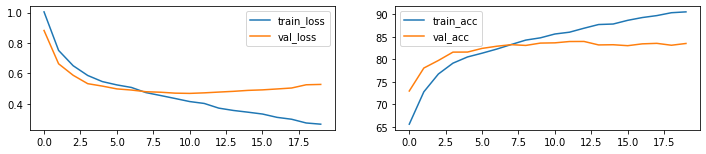

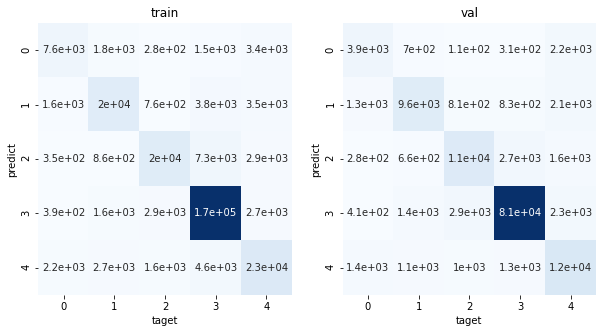

Loaded pretrained weights for efficientnet-b3
Kfold: 3 - Epoch: 1 - Train_Loss: 1.017546 - Train_Acc: 64.2832 - Val_Loss: 0.804870 - Val_Acc: 73.738082
Kfold: 3 - Epoch: 2 - Train_Loss: 0.735324 - Train_Acc: 73.7539 - Val_Loss: 0.634385 - Val_Acc: 77.621985
Kfold: 3 - Epoch: 3 - Train_Loss: 0.633847 - Train_Acc: 77.7918 - Val_Loss: 0.562877 - Val_Acc: 79.977566
Kfold: 3 - Epoch: 4 - Train_Loss: 0.572268 - Train_Acc: 79.8388 - Val_Loss: 0.525482 - Val_Acc: 81.561974
Kfold: 3 - Epoch: 5 - Train_Loss: 0.536642 - Train_Acc: 81.2057 - Val_Loss: 0.507811 - Val_Acc: 81.996635
Kfold: 3 - Epoch: 6 - Train_Loss: 0.523488 - Train_Acc: 81.7035 - Val_Loss: 0.484912 - Val_Acc: 82.417274
Kfold: 3 - Epoch: 7 - Train_Loss: 0.488955 - Train_Acc: 83.0004 - Val_Loss: 0.476123 - Val_Acc: 83.272574
Kfold: 3 - Epoch: 8 - Train_Loss: 0.462507 - Train_Acc: 83.8696 - Val_Loss: 0.458776 - Val_Acc: 83.987661
Kfold: 3 - Epoch: 9 - Train_Loss: 0.438751 - Train_Acc: 84.7809 - Val_Loss: 0.461058 - Val_Acc: 83.553001


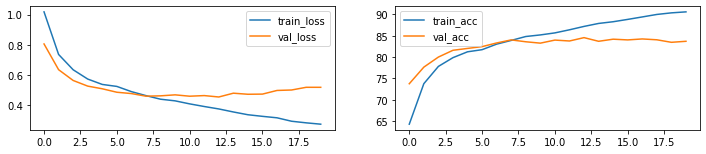

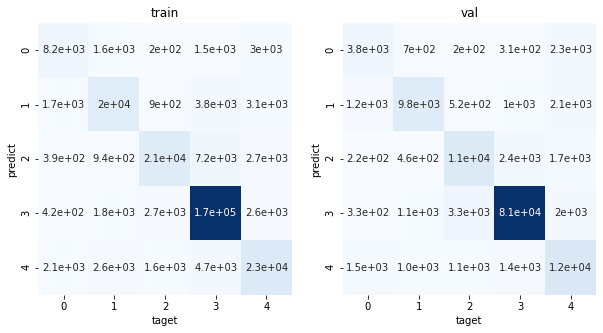

In [14]:
# n_splitsでKの数を指定
folds = StratifiedKFold(n_splits=CFG.n_split).split(np.arange(df_train.shape[0]), df_train["label"].values)
Save_histroy(init=True)
for fold_index, (train_index,val_index) in enumerate(folds):
    model = EfficientNet.from_pretrained(CFG.model_name)
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, CFG.target_size)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    
    train = df_train.iloc[train_index].reset_index(drop=True)
    train_data = ImageData(df = train, data_dir = train_dir, transform = data_transforms)
    train_loader = DataLoader(dataset = train_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    train_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    
    val = df_train.iloc[val_index,:].reset_index(drop=True)
    val_data = ImageData(df = val, data_dir = train_dir, transform = data_transforms)
    val_loader = DataLoader(dataset = val_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    val_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    train_epoch_log = []
    train_acc_log = []
    val_epoch_log = []
    val_acc_log = []
    train_taget_li = []
    train_pred_li = []
    val_taget_li = []
    val_pred_li = []
    for epoch in range(CFG.num_epochs):
        train_total = 0
        train_correct = 0
        train_loss_sum = 0
        val_total = 0
        val_correct = 0
        val_loss_sum = 0
        
        # train
        model.train()
        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = train_criterion(output, target)
            loss.backward()
            optimizer.step()  
            
            train_loss_sum += loss.item()
            train_total += target.size(0)
            _,predicted = output.max(1)
            train_correct += predicted.eq(target).sum().item()
            train_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
            train_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
            
            
        train_loss = train_loss_sum / len(train_loader)
        train_epoch_log.append(train_loss)
        train_acc = 100.0 * train_correct/train_total
        train_acc_log.append(train_acc)
        
        # val
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = val_criterion(output, target)
                val_loss_sum += loss.item()
                val_total += target.size(0)
                _,predicted = output.max(1)
                val_correct += (predicted == target).sum().item()
                val_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
                val_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
                    
            val_loss = val_loss_sum / len(val_loader)
            val_epoch_log.append(val_loss)
            val_acc = 100.0 * val_correct/val_total
            val_acc_log.append(val_acc)
                
        print('Kfold: {} - Epoch: {} - Train_Loss: {:.6f} - Train_Acc: {:.4f} - Val_Loss: {:.6f} - Val_Acc: {:4f}'.format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
        Save_histroy(init=False)
        if (val_loss < CFG.checkpoint_thres_loss) & (val_acc > CFG.checkpoint_thres_acc):
            CFG.checkpoint_thres_loss = val_loss
            CFG.checkpoint_thres_acc = val_acc
            path = create_directory + "./"+ CFG.model_name + "epoch"+str(epoch)+ "_Acc_" + str(val_acc) + '.pth'
            torch.save(model.state_dict(), path) 
        
    Plot_Model_History(train_epoch_log,train_acc_log,val_epoch_log,val_acc_log)
    Confusion_Matrix(train_taget_li,train_pred_li,val_taget_li,val_pred_li)